<a href="https://colab.research.google.com/github/DougJ/DougJ.github.io/blob/master/DL_MV_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ResNet50 Architecture on Covid X-Ray transfer learning.

* Authored by Doug Johnson  and Jie Dong

Some code borrowed from Machine Learning Mastery and other websites. 

## Summary

Details:
* Use .npy tensors to train and test on
* Create VERSION GLOBAL VAR for output weight and model files, update each time
* ReduceLRonPlateau and Callback  
* ImageDataGenerator added zoom, crop, rotate ...     
* Train test with imagenet weights and or train on loaded weights from a different dataset   



### Next Steps


*  Convert X_train and y_train to pd.dataframe from np.array, explore  
*  Load model weight combo for prediction new   
*  GridSearch     
*  Use GitHub as source code repo for notebooks       
*  Multi-class classification  ?      
*  Research medical pre-trained imagenet ... Stanford, 1000 lung  

#### General 
* New tensors with covid images copied again and again
* Put in confusion matrix
* Review performance stats and charts, accuracy vs val accuracy 
   LR in background, want low val_loss (.3) and loss (.5) accuracy val (.7+)     
* Create process for importing images and creating tensors that all can reference, automate. 
* Debug API Anatoly, why not working, what issue?  
* Images being standardized prior to .npy tensor? 
* How many channels, 3 or 1? What best? Diff X-Ray diff channel? Diff algos, discuss ... Jie dividing by 255, make sure understand process as quality data in is important.        
* Understand tensor .npy creation process, document   
* steps_per_epoch = DATASET_SIZE//BATCH_SIZE  how know this, how relate to .npy tensor and learning rate reductions?
* Debug Anatoly/Jie the programming of functions for commoditizing the model architecture. Like Rubik guy. Seems we should be able to all have ability to test off of same models quite easily. Think it through.

  

## Import Modules

In [0]:
import sys
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import backend as K
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input

from keras.optimizers import SGD, Adam
#from preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# LOAD DATASET
from os import listdir
import numpy as np
from numpy import asarray, save
import pandas as pd

from sklearn.model_selection import train_test_split

# PLOT IMAGES 
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

# METRICS AND REPORTING
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error


## Global Variable Designation

In [0]:
VERSION_IN        = 'V1-2_Adam' # Adam is optimizer 
VERSION_OUT       = 'V2-2'

BASE_PATH         = '/content/drive/My Drive/'
DATASET_PATH      = 'images/Preprocessed_Tensors/COVID_IMG_preprocessed_balanced/'
OUTPUT_PATH       = 'images/COVID_19_project/pretrained_weights/'
FOLDER_PATH_TRAIN = BASE_PATH + DATASET_PATH
FOLDER_PATH_TEST  = BASE_PATH + DATASET_PATH

WEIGHTS_IN        = BASE_PATH + 'ResNet50_weights_best_' + VERSION_IN  + '.hdf5' 
#WEIGHTS_IN        = BASE_PATH + OUTPUT_PATH + 'ResNet50_weights_' + VERSION_IN  + '.hdf5' 
WEIGHTS_OUT       = BASE_PATH + 'ResNet50_weights_' + VERSION_OUT + '.hdf5'
WEIGHTS_MODEL_IN  = BASE_PATH + 'ResNet50_model_' + VERSION_IN  + '.h5' 
WEIGHTS_MODEL_OUT = BASE_PATH + 'ResNet50_model_' + VERSION_OUT + '.h5' # IDEALLY INPUT RESNET AND MODEL/OUTPUT FILE CALLED

IMAGE_SIZE        = 224   
INPUT_LAYERS      = 3     # RED, GREEN, BLUE = 3; IF 3 REMOVE FROM ImageDataGenerator
LAYERS_TRANS      = 3     # GREYSCALE = 1; FOR MEMORY AND RUNTIME EFFICIENCY CONVERT TO GREYSCALE, !!! DO SOME REQUIRE 1 VS 3?
NUM_CLASSES       = 2     # NUMBER OF TARGET CLASSES, BINARY - TRUE OR FALSE = 2,CAT OR DOG OR CHICKEN = 3 ...
BATCH_SIZE_N      = 16    # MEMORY MANAGEMENT, INCREASE IF HAVE LOT OF MEMORY
FREEZE_LAYERS     = 2     # !!! READ UP ON SIGNIFICANCE
NUM_EPOCHS        = 50  
VERBOSE_EPOCH     = 1     # EPOCH OUTPUT 0 = NO OUTPUT, 1 = OUTPUT

## Access Tensors


In [0]:
# MOUNT GOOGLE DRIVE TO ACCESS SHARED IMAGES FOLDER
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# ls /content/drive/My Drive/images/NIH chest X ray images/images_001/images/
ls /content/drive/My\ Drive/images/Preprocessed_Tensors/COVID_IMG_preprocessed_balanced/

X_test.npy  X_train.npy  X_val.npy  y_test.npy  y_train.npy  y_val.npy


In [0]:
# TENSORS 
X_train = np.load(FOLDER_PATH_TRAIN + 'X_train.npy')
X_test  = np.load(FOLDER_PATH_TEST  + 'X_test.npy')
y_train = np.load(FOLDER_PATH_TRAIN + 'y_train.npy')
y_test  = np.load(FOLDER_PATH_TEST  + 'y_test.npy')

In [0]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

3424
3424
1472
1472


In [0]:
# Anatoly's loop to take array from 1 -> 2 dimensions
y_train_new = np.empty((len(y_train), 2))
for i in range(len(y_train)):
  #print(y_train[i])
  entry = [0.0, 0.0]
  if (y_train[i] == 0): # !!! 0 = NORMAL, 1 = COVID
    entry[1] = 1.0
  else:
    entry[0] = 1.0
  entry_np = np.array(entry)
  #print(entry_np.shape)
  y_train_new[i] = entry_np
print(y_train_new.shape)

(3424, 2)


In [0]:
# MAKE SURE FIRST ELEMENT MATCHES, SIGNIFICANCE: IF THEN WORKING CORRECTLY
print("new first element {}".format(y_train_new[0]))
print("old first element {}".format(y_train[0]))

new first element [1. 0.]
old first element 1.0


In [0]:
# ANATOY - DATA PREPROCESSING FOR TENSOR ELEMENT BALANCE
y_test_new = np.empty((len(y_test), 2))
for i in range(len(y_test)):
  #print(y_train[i])
  entry = [0.0, 0.0]
  if (y_test[i] == 0): # !!! 0 = NORMAL, 1 = COVID
    entry[1] = 1.0
  else:
    entry[0] = 1.0
  entry_np = np.array(entry)
  #print(entry_np.shape)
  y_test_new[i] = entry_np
print(y_test_new.shape)

(1472, 2)


In [0]:
# MAKE SURE FIRST ELEMENT MATCHES, SIGNIFICANCE: IF THEN WORKING CORRECTLY
print("new first element {}".format(y_test_new[0]))
print("old first element {}".format(y_test[0]))

new first element [0. 1.]
old first element 0.0


In [0]:
# 10% COVID CASES ROUGHLY, REST ARE HEALTHY, SHUFFLED
print("Shape of tensors:")
print("X_train:     {}".format(X_train.shape))
print("y_train_new: {}".format(y_train_new.shape))
print("X_test:      {}".format(X_test.shape))
print("y_test_new:  {}".format(y_test_new.shape))

Shape of tensors:
X_train:     (3424, 224, 224, 3)
y_train_new: (3424, 2)
X_test:      (1472, 224, 224, 3)
y_test_new:  (1472, 2)


In [0]:
#ls /content/drive/My\ Drive/images/Preprocessed_Tensors/
#ls /content/drive/My\ Drive/images/NIH chest X ray images/

## Define Model Architecture

In [0]:
def define_model_resnet50():
    '''
    ResNet50 model using imagenet weight file for transfer learning.
    Freeze layers. Trainable freeze layers, others, not
    Optimizer is using learning rate, better to use Adam or SGD and .00001 !!!
    '''
    # !!! GO TO KERAS DOCUMENTATION ONLINE AND LOOK AT PARAM
    net = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMAGE_SIZE, IMAGE_SIZE, INPUT_LAYERS))
    x = net.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
    net_final = Model(inputs=net.input, outputs=output_layer)
    for layer in net_final.layers[:FREEZE_LAYERS]:
        layer.trainable = False
    for layer in net_final.layers[FREEZE_LAYERS:]:
        layer.trainable = True
    #net_final.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    net_final.compile(optimizer=keras.optimizers.Adadelta(), 
                      loss='categorical_crossentropy', metrics=['accuracy'])
    # CHANGED TO momentum, TO DECREASE LEARNING AS EPOCHS PROGRESS
    #opt = SGD(lr=0.01, momentum=0.9)
    #net_final.compile(optimizer=opt, 
    #                  loss='categorical_crossentropy', metrics=['accuracy'])
    #print(net_final.summary())
    return net_final

## Define Learning Rate and Callback Checkpoint

In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# IMPLEMENT LEARNING RATE REDUCTION BASED ON VALIDATION LOSS
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', # DECISIONS BASED ON val_loss
    factor=0.2, 
    patience=4, #IF MODEL DOES NOT IMPROVE BY EPSILON IN 4 EPOCHS, THEN REDUCE LR BY FACTOR.  
    min_delta=0.0001, 
    cooldown = 3, # WAIT 3 EPOCHS BEFORE STARTING AGAIN
    min_lr=10e-5, #min_lr=0.0000001
    verbose=1)

# SAVE WEIGHT FILE FROM BEST RUN, HAVE VERBOSE OUTPUT BASED ON VALIDATION ACCURACY
checkpoint = keras.callbacks.callbacks.ModelCheckpoint(
    WEIGHTS_OUT, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

## Plot Diagnostic Learning Curves

In [0]:
def summarize_diagnostics(history):
    '''
    Plot entropy chart
    Plot accuracy chart
    '''
    
    plt.figure(figsize=(8,10))

    # PLOT LOSS
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # PLOT ACCURACY
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()
    plt.close()

## Define Test Harness

In [0]:
def run_test_harness():
    '''
    Test harness calls model definition function 
    Resizes images
    Creates more images with Image Data Generator: rotate, shift, shear, zoom, flip, ...
    Fits the data
    Gives performance summary
    Calls the learning curve graph
    '''
    
    model = define_model_resnet50()
    model.load_weights(WEIGHTS_IN)
    
    # SPECIFIC REFERENCING imagenet IN BACKGROUND?
    #train_datagen = ImageDataGenerator(featurewise_center=True)

    # CREATE DATA ITERATORS
    train_datagen = ImageDataGenerator(rotation_range=15, 
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range= 0.2,
                                      zoom_range=0.2,
                                      horizontal_flip = True)

    # SPECIFY imagenet MEAN VALUES FOR CENTERING
    #train_datagen.mean = [123.68, 116.779, 103.939]

    # WORK WITH TENSORS
    train_batches = train_datagen.flow(X_train, y_train_new, batch_size = BATCH_SIZE_N)
    test_batches = train_datagen.flow(X_test, y_test_new, batch_size = BATCH_SIZE_N)

    print("train batches {}".format(len(train_batches)))
    print("test  batches {}".format(len(test_batches)))
    print("\n")

    # FIT MODEL
    history = model.fit_generator(train_batches, 
                                  steps_per_epoch=len(train_batches),
                                  callbacks=[lr_reduce,checkpoint],
                                  validation_data=test_batches, 
                                  validation_steps=len(test_batches), 
                                  verbose=VERBOSE_EPOCH,
                                  epochs=NUM_EPOCHS)

    # SAVE TRAINED WEIGHTS
    model.save(WEIGHTS_MODEL_OUT)

    # EVALUATE MODEL
    _, acc = model.evaluate_generator(test_batches, 
                                      steps=len(test_batches), 
                                      verbose=0)
    
    print("\nAccuracy > {:.3f}".format(acc * 100.0))

    # LEARNING CURVES
    summarize_diagnostics(history)

## Run Test Harness

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


train batches 214
test  batches 92


Epoch 1/50
214/214 [==============================] - 73s 341ms/step - loss: 0.5496 - accuracy: 0.7138 - val_loss: 0.6344 - val_accuracy: 0.5496

Epoch 00001: val_accuracy improved from -inf to 0.54959, saving model to /content/drive/My Drive/ResNet50_weights_V2-2.hdf5
Epoch 2/50
214/214 [==============================] - 57s 266ms/step - loss: 0.3987 - accuracy: 0.8221 - val_loss: 4.1783 - val_accuracy: 0.5503

Epoch 00002: val_accuracy improved from 0.54959 to 0.55027, saving model to /content/drive/My Drive/ResNet50_weights_V2-2.hdf5
Epoch 3/50
214/214 [==============================] - 57s 266ms/step - loss: 0.3518 - accuracy: 0.8478 - val_loss: 1.0894 - val_accuracy: 0.5265

Epoch 00003: val_accuracy did not improve from 0.55027
Epoch 4/50
214/214 [==============================] - 57s 264ms/step - loss: 0.3342 - accuracy: 0.8548 - val_loss: 0.5660 - val_accuracy: 0.7643

Epoch 00004: val_accuracy improved from 0.55027 to 0.76427, saving model 

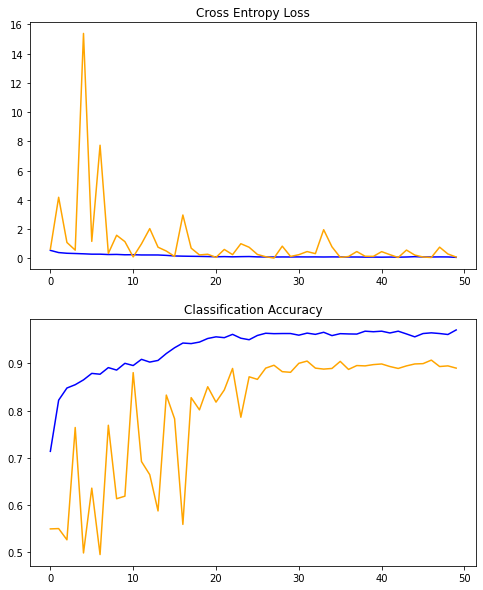

In [0]:
run_test_harness()